In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [2]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 326s 0us/step


In [3]:
 # Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 30000 captions from the shuffled set
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [4]:
len(train_captions), len(all_captions)

(30000, 414113)

In [5]:
 def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [6]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 2s 0us/step


In [7]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

In [8]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [9]:
#Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [10]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [11]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [12]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [13]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [14]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [15]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

In [17]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [18]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [20]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [21]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [22]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [23]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [24]:
 optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [35]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [36]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [33]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [34]:
 @tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [39]:
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 2 Batch 0 Loss 0.8275
Epoch 2 Batch 100 Loss 0.8868
Epoch 2 Batch 200 Loss 0.7166
Epoch 2 Batch 300 Loss 0.8249
Epoch 2 Loss 0.792287
Time taken for 1 epoch 281.5553126335144 sec

Epoch 3 Batch 0 Loss 0.7306
Epoch 3 Batch 100 Loss 0.7477
Epoch 3 Batch 200 Loss 0.7024
Epoch 3 Batch 300 Loss 0.7059
Epoch 3 Loss 0.722072
Time taken for 1 epoch 348.9744257926941 sec

Epoch 4 Batch 0 Loss 0.7215
Epoch 4 Batch 100 Loss 0.6967
Epoch 4 Batch 200 Loss 0.7122
Epoch 4 Batch 300 Loss 0.6524
Epoch 4 Loss 0.678214
Time taken for 1 epoch 351.9847242832184 sec

Epoch 5 Batch 0 Loss 0.6500
Epoch 5 Batch 100 Loss 0.6689
Epoch 5 Batch 200 Loss 0.6534
Epoch 5 Batch 300 Loss 0.6593
Epoch 5 Loss 0.643067
Time taken for 1 epoch 352.1866147518158 sec

Epoch 6 Batch 0 Loss 0.6177
Epoch 6 Batch 100 Loss 0.6858
Epoch 6 Batch 200 Loss 0.6082
Epoch 6 Batch 300 Loss 0.6208
Epoch 6 Loss 0.612482
Time taken for 1 epoch 352.9162003993988 sec

Epoch 7 Batch 0 Loss 0.5533
Epoch 7 Batch 100 Loss 0.6235
Epoch 7 Batc

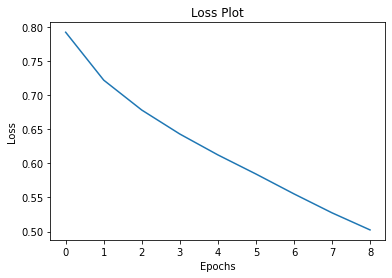

In [40]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [41]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [42]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> some people gathered around tables drinking some wine <end>
Prediction Caption: a group of people sitting around holding onto wine <unk> <end>


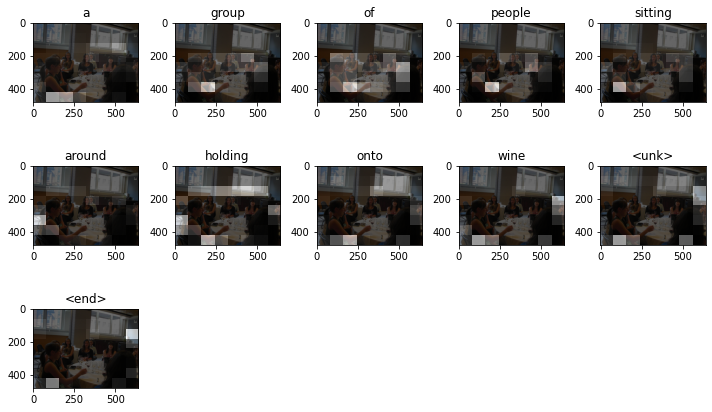

In [43]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

65536/64400 [==============================] - 0s 1us/step
Prediction Caption: the surfer riding in the waves into the surf <end>


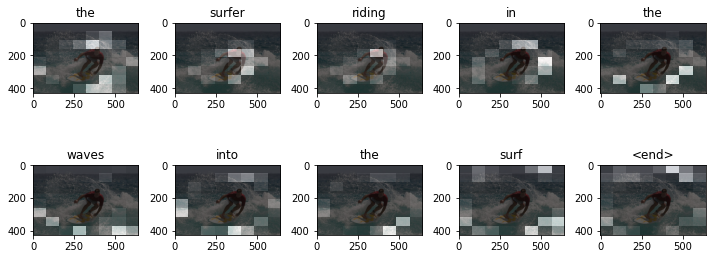

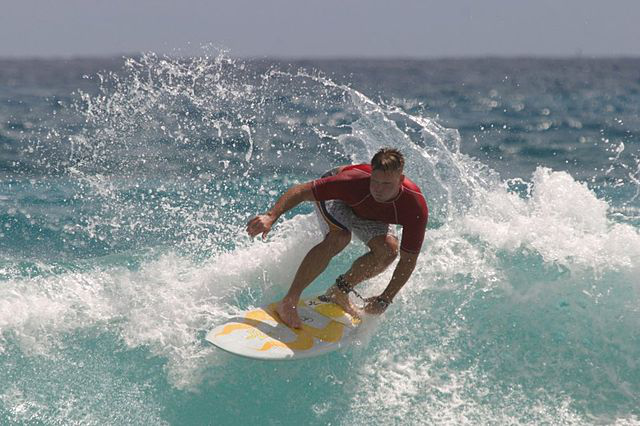

In [44]:
 image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

32768/25222 [======================================] - 0s 0us/step
Prediction Caption: a young girl holding up is trying to server a racket <end>


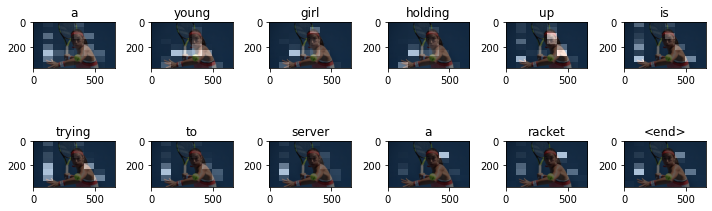

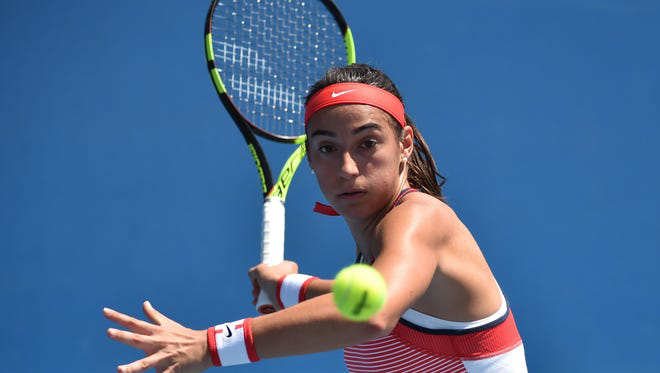

In [45]:
image_url = 'https://www.gannett-cdn.com/-mm-/421ea65e01b192561ce99d096ae7be7d6243ff79/c=0-209-3600-2243/local/-/media/2016/01/25/USATODAY/USATODAY/635893239999985666-C08-LAUNDRY-25-78972226.JPG?width=660&height=373&fit=crop&format=pjpg&auto=webp'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

16384/9982 [=================================================] - 0s 0us/step
Prediction Caption: two men playing with a soccer ball back end of grass <end>

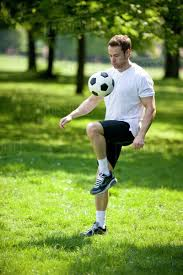

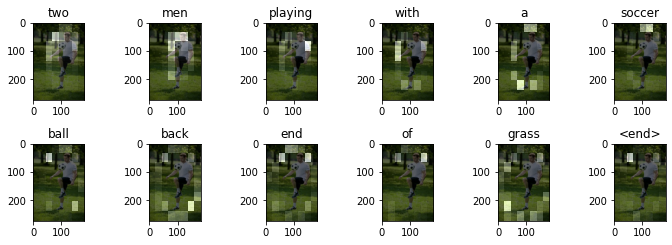

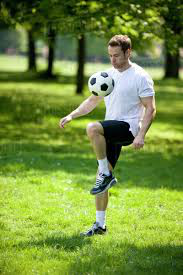

In [52]:
 image_url = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMSEhUTExMWFhUWGBgYFhgXGBgdFxgdFxgXGhcZGBoYHyggGBolGxYXITEhJSkrLjAuFx8zODMtNygtLisBCgoKDg0OGxAQGy0lICUvLS0tLy8tLS0tLS01LS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS8tLS0tLS0tLf/AABEIARMAtwMBIgACEQEDEQH/xAAcAAACAgMBAQAAAAAAAAAAAAAEBQMGAAIHAQj/xABAEAABAgQEBAQEBQMCBQQDAAABAhEAAwQhBRIxQQZRYXETIoGRMqGx8AdCwdHhFCNSFfEWYoKS0lNyorIXMzT/xAAaAQACAwEBAAAAAAAAAAAAAAABAgADBAUG/8QALhEAAgICAQMDAwIGAwAAAAAAAAECEQMhEgQxQRMiUTKBkWHwBRRCcaHBI1Kx/9oADAMBAAIRAxEAPwDk1XICZaVI3A994ETcX1i5UdPLXLykNlDfLWKniUkiYwDaNGPDl5tr4EaJDQAIzak6CBamSxbSG9DSeUkqdg7dogUhRU6UW6wyyb7gIJAAYBOZ+YtDAJCbAQVjdWmdkEtAl5UsW1J6wqcjUxVbmrev0Fkg6TPUAQg317RGsLJKixiamlbtEk+WTYAxXySZAFVTLSpiGJ3P3aD8P8FanmFdhbKNfWE8+SrXK7awzw6sdwryggAABvWHyR9toiGFdilGuWmX/TnM7hTX139Is3DmCU82UVLQE8s0U8JkA/Con69+UFoxwol5CknZtox5cMnBLG2vuNfyGYtgCJQXlWARcZd+8IEyk5CsqKlOzfq8e1M1c2520v8AbwdSVCAkgoL7GLUpRjt2DTFapcxwQO1oYmoSpjMQCpmcQbJCVSlKXMDgjKAPl0MEUnDsyaM4TllsTmUQx6d4EssdctESIabh4zqZU+XOHlLGWUl/QiAcXwYyAg+IheYP5FOU94JpMUVS2RmGoUDoeoguon00ynTlQpNS5zkHyKfUnke0OpP7BpMr9OgEOCSoN5YLq6mcwQlJD6gix7EaGLpwzQUcyWlMxs5DHu0QY3h4lpypmBKQbE39H27xmfVRc+NDJFGFLOWCVBQCdAQduUCTKla2zKzMGDw3kY+tJVcNy/aK+pQzEsLkkRvxpvuhGMkYXMWlP5eRO/aMiKmWpVnPS5YdoyBKUk6v/ASWjrdRYFrcrQVKo0TUFZLKTa5hQigUYe0WHDy9CHf5wckOO4gsGqJcxKRLEvKrVwLkd40VSLScyzaOoHD5U5AIAcM3MRUsdmS5WZChfaMqyz0uI3Eq6piElnAJjeZLSsO9hvACpWZTtD2mwweEo5thGiVRrexRZLWFWzFh0hhRpB0CjtcmAqWolpWpKn1ADdoY0ShlcuG063hcqrwAKp5UsAgpPUM+nMwJPlufKyUvbR4nMwh8tswLiAa2atzlALNr0EVxTsjPEYaopzhbsWKXuGLQ1w2hllBSqXmUVWU9xaFtBZeZQcEe13huMQVpLQSQbN2g5XLwMqDKfC1Ui5a5yEqlrLc7GAOKKdlkyiPCPwgWZ4Mo6idMlMuWpZSXGth2hdU05nrTfKkFlD+IoUWp8m/GwNa0WngEJEgpWgKCnBcD5PByKabRnw6Rp8tTq8Im6Hu4J2faFVNRJpyMqjlAdiYsuES5DGolKyTCDmvYjqIw5ckXbltNjIr2I4BPnq/vIQAbhKTcH/mhMOHAqYqWlbTEswFwYuON0VTMHjyzmtcJLH+Yq+FHwVKUsMp3cllPGjDk9lx7fBA+kwiXSKy1iVJJGZBCrH2Pyg+pxannHw1ykoBDCYzg8tNIrVfUeKHmOopvqbenKCKerT4dkWfflFnpqUuW/wBAplf4zwgS8qkEA6MNxFZlzVJcsNGiw4pKeY6l2UWvduREKcXoVIAIGZH+YFu0dLFJNcWB7ZmHrUXAGu0ZAtItSlMkaRkScN+AVRZqaW8N5CQ0KZZEHyAQHMaZKxEWvAHB6RVPxIQy0kDeLNw7OJOlhFZ/E+cSRZr6xjjH/kHTFFHKzpAAgiZJUhCkizt0hp+HAQpLqDm8P8cwfxAVITpEljcXoXbdHJ1yVeKHUlydotsmjT4YvCNMkGaRukt7RaZDZRF2prYJsETIQBdyY1/pUhSc7JSd3t6weJTwNxJL/sntFU4bFi9i/CageMtIyqALAgWhyEKzuktyaKlwyfPF4ky94k4JaGn30bS585CtWHNOp7ws8OaqZlSklaywbUk6Q2UsxsiVUBMybIQCtCd9gbHLzUfoDFPpW0hoe50PMO4bRKCBVTF5i/wFISALEEqFy+7jpBQ4YkZiKebNdaLIzJIBPK176jZ9Y55Lqa9YyzUrVLckgm4ezp5GFVPxLVSFhPiKARZnP27Fni5dNBrsa+MF3RbabGanD5i5EwMUquhRex3SRYgiF9XWCdWIWwCSz5vh6loWYxiiqoypq/jKCFf9KlM/vHtAkBwp76GMksMYSbWmZpadF/qq+hKmEhClBnUkBiTt1hRVYMopK5Qyg6Szv29IWUkkhYKYvVIDlBKXbSK+M5SpPf8A6MtnLMVkLSBmQQp7uIEOZSShSiEm+XbvFo47rFFQ2AOohHTeZQTmA5GNPuil8iPTAEU6JSnRvqIyNauSsLUwKgDq0ZFquu5LZZKbApoU5SWhyuiUbBHyjpgoE/4iJBQJ5QY9XfcaLpUcsTPmSVOEEj1io8aV6ppulo76vCkKdxHJ/wAXcPRKCSkM5gwywclrYvkS/h/iiJQIILudI6YjF0KkEt7xz/8ACrDETirM1jHQMewQIkqyW7Q0pQU2PF07OL00zNWzDsVq+sXCawZorHCOGKn1a0i+Ul/c/tHT1cGzCRcNFjnCLplclbK5LTCrig/29YudTwpN/KRaKtxjg02XKKlC0L7X5FSplW4bUy4u8uaIpfDVIqYpkgkxdKbB5oIzIVrD8Yy7saUbZ6qY0OcGxAJCwpWUEC+1jvy13hTX4ZNAfKW7R5gYWJqQtDoJZQIsxsde8K8Sq0ww9k0MMVr0OUhTkWIALA99Hil1eChVSCzhQKiCdSCGHa/yi350mbMKkpBBOUkB99OmkK5hCpg8176DnrAWjdJbGkrh6VNTmsD5rAMB5jpyDubWvCGbJEtWUj4TFyxnBKiSrxJKFzJMxIWgoDhKSAcpA0I06tFbVUpUWKb9YHoJ9zHllcmxxhEmWtIYgKi4YVMSJZSpnjntJVhBdOUfxDIYwSHzADp1iufT1JOJI5Eiv8dLGdZby7Qhopskys13diOXUQ24vqAqU+94otNMIcRZLEpruBK9nT/w9VLmomIUXZVrCPIrXCM0AHzFJ5iMgca0WxyJKjuEjiKSfzD3gyXjck/mHvHEkVcpv5iH+vbT6mMCi/BTZ3b/AFiT/kPeOTfirWpqVJRLLsXMIZmIEjWBV1oh4JppksY8A1Ap5inLBgf3i44/x1JElSQpy0csqqknQe0KajOdXi1dP6kuUmQu34UzstRMmczf1c/rHb6SpEyPmPCK2dTk5N4v/DmPT0jNY93hOqxyU+SeiM7YiQADoY5/+ME1KKZXWw9bQJJ49mgsUX7xUuP+IJlSkJUGDwsLckiJjT8GaQKVMJD3EdkNGi3ljgP4fY+aUqs4Jjs1LxHIlSZc6sWUeKMyEMpRy7KUEg67D7GhY5TyNILodKoEkfC/pGicCl6kAel4ziSlmzpQTJWmWpJcAg5VWIykpukX1Y9oS8LJq5QmGpyBJIMtAWVqT/k5ZgDZgCdNnaNkelj3bBexNxjwSQVzpKgEWJDHMm19Bpv0fpFZwfAZi1eROa5dWiR3P2Y7ImelSQpJCgq7i7v/AD9IFVLGgAA5DTqYtWBNlvrOgfhWmVTyxLKipyHd2GzJGwiHiTganqXWlPhzTclNkq/9w0fqPnDFBy35RN/qOW6r/wA/fziyWL/qV8r+o5zN4BKTclwTHv8AwUQ946TMmeIkKA7fsYRKx2UHuLRzM854nTZOKONfiFgxp0DlHP5Ijpf4pYr/AFREqWHYuTFCGDzUh8sPjypxuTJos3BOBLnJK06OR7RkWv8ACWqTKlGXMsXJv1jIql1NNosTjXYLl8CyTvE0zgiQ2sBHGCC2Yx7NxJbhlExybyfItBUngKSdz7xL/wDj+RuTAsniA5t4Kn4oSx80FufyCkDT/wAP5exgWZ+HwexhzLxsm17QxRjqQL27xOeReSUVYfh0Oca/8FzEBkrt2i5IxlB3gyVXyyNRCPJlvuCii0/As7XOPaKlx5g0ynAKiCCWjtH9cHsqOZ/idTTalSQi4Bcxo6fI/UXJkSKlwtQqmu0dgx/gyZV1MqYJqU0/hy33WnIAMiBoxF3Ol7GKj+H2EhCWXZQ16xccax+pppctcqQJspBKZtzna2UpblvY7aRtwdXWeUfwRqxhx3xenD5ImKQVlasqALB2J8x2DDrFa4S47/rpSyUZJkojOA+QhT5SCdPhNukEYwmmxaklmZnCHzpAOVaFDMkhWo3MJ+G8HlyyaSkC1DPmmzFXCXsM6gAHADBAv0uTHQjmUnSEaLj+HKJgo0pmWKVzgOTeIoAjpqR3ixTFRDSShKlhCdALcyz39bmA6ioN+kbYk7Bc2cPcwHMqHA7gn0B+/WAvGJLxrTIUQoJLOtRKjoNGA5wbFHWGrmCyTfUA6G2nQ2Hzjm3FeFzP6qcpCWSVkt/9rdS59YuX9AxCyslXPzKPe1vQMIQcYYrlnMi4UhKiSGuXB3OrA+sc7+JRfFSXyOmq2VORhkwn4LwbMw2aE3lxpT4ysH4RDNHEqmYojiz5EVFdTmSfhIPQRkO5mMpCnKTGQwdfJQJVQp3cw9wrEcoUVXJ5wglpLRNK1aLpJMVMerrktYXeCpGK9IVVstGVLG8DgDLFPFNDWyx09aNWcwcpYUASO7xX8Pp1zB5WGW8SSMQKCc+gaE4Ess6fDZnESSpaP8oq6sXSVFgwcfONVYpbynuIR45E5ItP9UAWd4mTVpOwioCtUXIVse8W/hrhadM/v1AKJKWUEmy5lrBtUp6nXbnDwwObpBWxzguDhf8AdWckvoPMpuXIdYzEZyiSzBAskdIIr8VCjlDAAMBt0ivYxjKZIbVZ0Ty6nkPrHSjihhh/s0xSgrYWkszkk8v94ushKcqAgBKfiAAAGnId45KjGybkOY6PwtVGbSS1kXOZI7BSgPkInQZZSyST7Vr9/czznyYfMU7nbQekKp5vpDeYmwhPUzWJ9Y7CK2CTJRNwISVkxcqa6VlOYMsJPLQn3I9YaLSpZs4B0PP+I9kYYCpiHHw9CTZ/nFeZNx0PiSvYhrQZgOZaldyT9Y04rwoiZKb/ANGWP+3MkfICDKmiTJ8VIUSkKUEk625/T0ierr0zZVPMUMrpUgE/m8MgOOnmjj9VJrHbNOWKcNFXVhyk3eNUUaidYsMxMtX5ohmoSjQxzfUbMvEWHC1ncRkM0YkBv8oyF5zDxRU/9LSNxeF9agIETSwpZy5/eCajBlgAkgiL0+L9zFYlE8KbprEyVp52guVhXmbYwylYDLsSbQ8skEShVT1C3yoJFrwwp8MVNSSenrBSsCAVmQoaQ3oKfw0eciKp5FXtew8RT/w2spzJH8tEEjhypWrIhDnm4AA5qJsBFppsRLEe0S/6ikSlgvcpC8pY5b77JfU6gPC9NLJPIoyegwx8nQz4U4JlyUGpnTETpiXKQH8JJHdvEPyfnCjF+LFLLqK1HZKQwHS9o3kzBmBWokBmSD/bHKw1brDennUxucvyi3N16g+OKOvkdy46iUqdiVUv/wDXJy9blX0Ye0JZtNNc5kqclyS5J7kx2GinSSQEgXtEmLzaaWzJzK3tAwSz9RbpUvlicZT8nF8qwdD7R2fhiWpFJIQQQcgJ5urzH6xQuPFf2jOkKUkpHnQ/lKd1DkRr2eOX1GMrUfNMUruomOx0eD07k2hHFxdH0vXVIBCdDy5cnhahEtZPnD7gX17R86y8ZmILomLSeaVFJ9wYPw3j2vkKzS6mYeaZqjMSW2/uOR6ER0VOKJtn0DMlJS1lk/8AKk/U2EeyyzsggIGY+0KeHuIDV0smoIYrSSU8ilRSpujpt0IhhPEpcmYp/wC4FIe+gILD/wCJPpC5nUCzH3Krjs4kKewLlXrcxWcZxIzPDSlwmWgAAaXZ29h7Q6xlBnTEU8u6phYnZKRdSvQOfaGw4QlgNeOB1ueMGostzT1xRRJNUobmJTWr5mLhN4OSLuwhRVYCUlkkRhWaEjPsrk7EldYyGVVgaxe0ZFqyY6BbA5lQkiyb9DBKJoy+cn3jeXgqEpBKr94gn0IJYKBHWBSfYNmT5sphkVeJZEtZ0LxHTYOGJUpLW0aCDJEseVesFquxLNkomMRlMbS6CoUks7DZ4npUqIDTQH1doYy6WYi6JjvqIrlKg9xDJmEA5gQRG0ipJDhJf6w+Xw74gBzXOsFyeHVS5RylzA5rwFWVxGMlsmRho8RTUuCpLsINn0KkEkgR5QIyg51MDE9v1IH9yLBq1aZ0s+bKDfVr2/WH+K1KwCymJPrCeRO8JRyjOILIKwFEEWNj0jX0+WnxL8MkrRXcWrFhCszlBBBIuA4u8cuCo7HNWACOccoxmmEudMSLAKsOhv8ArHTwumyZEB5o8JjdEonQRngndh3MaLKtHYPw04t/qJH9LMCEqp0AS8obNLACSVXuoFnNviEWKWjyFbtnZ+ybD3jlX4Z4QZtYmYVFMuU6lqDsbMEFWl3uNwDHXMWnpWChJfaxFrOB9IE5uSotxx/qCeEsICQqpWRnm2R/yoBt/wBxD9gmLIuWhVnDxR5OLhAGUqLDKEm2ltIj/wBaKvMPKrvHmMrc5tsR7ZdpmFFViu0B1PDycpaK1P4gqEIzAj1EYrjVZQCA6t0wnFVpAonruGZgDpUezxkDSeNlLBCkEERkDhNeAcSjeKSPMS7D6xIV6dj9IGnqAV8b32GsSAvo8dTizM5HgzMbFrRpnUCxg0LUEsEsNTHnivEcWCwQKV1EGysRWjRRjwlixF41l1TFikawso/KIpBc7HZiCFBTvrEKuJJq7BagOhtEs2fLUGKQwjeUKdriEait0NyIkVhILqJPeCUYgCPMA0Q/1UkOBL1jeZUyiwCG5wrivgnIll1gHwmDaSuUpWVVwQWgeQabIbsqC/EkZUkK80Jai9JjwnTsUYgplRznij/+hfp9BHUcVpFKIKUk5gCGBOtxHPOOaBcmoGcMVoSv6hu9vnHX6a3s0yZXkm3rHV8BwHDf6aQqdJzzih1krWxJ8zFIIFgQNNo5rglAZ82XLH5lh+iQHUfYGOrClQk6Ejl6RX1uSqinXnRTOVB0yvR4XhSUIQgA5UpASB7anrAlNTJKs0xQACgSB+a9weVh84FqSpLFCMvWBDMe5WxjFGU1GkyLNJKi5zZssrBSzOXjSpVKCyAkPaKZMqD/AJmI11BOpMU+hbF9QulVMSgOQFBjaEVHXpUoslmiGgqw2VR6XMDVc7w1eRoVY9tB5jSdiITYIHUxkV2oxBRU5HpGQ/pP4J6gVKoyoi1ucMf9INiLpiSZSl8oJylmJDXaD00y0JAzO+n6vAlkyPsVcULTh+VwVMDb+IXKlZVaOAdOcWiZRFZBJCb6cud4kocJk5s6lHcNqIVZ5R+p2BxKidSfsR7MQDFzm4XJWVEJO23PeAVYIl2SlRHSLFnTewcSty6a1z/MbzpYZOV3/M+npFrpuGwpy7W3hlK4ZlKSGPc7Qf5qK0Dic/QkmNik8os1XwnMC2QxF4glYHNFilob1otA4sQ+HZ0gvuGtEbqBvDqowmcm99HtGIw2YoPld+kHmnslFo4PC1UIzXAmTPDP/KS47MoqHpFO/EbCBPSn/wBQJJSeoOnq/wBIuH+oIoqbLNdKEozqU3lSLj1KlggAOb6RWuNMUkmkTOkzEqZQ9j8Q6HS2sd2MJSwqu9GiNRkrKDwbRKSFTbguUjbT4vmw9IsomTE3cxqumUUeXyi5YdS/q7v6xsgkAAmORkk5ybZTN27NFVCyGe0RMXuInI5xrbaK1FeAWDLB2EYUwQpcQLSXvDUQyIZk31j0LAMbKHLeJxQbIDfWMjcojIawnZzQy1AkoDi/3840m4ZJmC4A6gXS3Jo1QgjKCWfnvE0pbkh7DUgaA9tY5Cm3Wi5oHmUstZbd2J6D9YyYhEpNkODcgDfmHgyWgX3+T+kTJ7C5a8Vvl2YtCuTXS1ZfKXI327QeiUlaEkNo9u+/WNp8tOV2BZ27/tGyVsNgGil6dWyGyKUF7P16R4iiAbzZR2/aNJM9lO7g6t9IME9JsRvry6GLI5VKKT8EB006cqiFszm/7atFerZuW5J5ARaaiUgkAF+raducJsQoMymKrA2s3rGicuKWl+QNCaTiiwfhdI+2iY42VjKlGVRswF4nVh6kk5WKTodzflCfiDGRTkI8AzFfmTl0BGh8pv6Rp6XG80koruLVBPEPEMtMhZmJBEsKZaVsQdGJQpSXOjZgeaGeOMyqBdTMCVEurzqzE5UJZyo8gBsO24iw8S19TUTE5EFGYZUyyormavmOYki/YDkLxZeEOGUmUuUtfnVl8dZublwhP/Yezbx6HqMsMMOU3SQybewTDzLVTqRL8UzELBC1N/cSoMfKLJYpDDkd48TTLUHZouEvhjIwllg9t7QUjh9Z+EpBO+0cCXWwzTcsa7iuNlFm0hQBvEcmU+otF8HCt/OQ8CL4TYDKS/KK49Ql9XcnEps6QRyEDFL2i2VfDCwHBJuWeBqfhaaSdms+0WQzwauwcWVf+kjxUpmaLhVcJLYXuEjT8xfXtCiZgc7OyU8xfaJHqIN9wuLEkwGPIYrw2YCxBtY2jIuU4vyCmdOQWIUzvbmzamJJdOWIJbm+pvu22vvENOuYp735sCCGNtdRBUub+UkFmB+WoG93jjOTi02XM9SVApG29rczrqIIRJdwSx/3iGZUFPY/UXt6RFT1GYnmOfR39NIjyqTAGy1AAj79IwIvo/RoxCho2vX7a0RIStLl/vrDvVMhJLSNPD2LW0fa0bLk5lBmAJBLDl30iPxFWv8ATaJJNxct117fWGhK3Xf8ENahkl35/wAxGDsRbr1iZiAVHKQPc8vX0gU5ibg99OVuu8V5cDT5LyCgkqaxFk9NOfaEXEPDcqe81ZmBTOcpYKYMHboIby1JAJAN7sx++URqSrKoNse9xFmKcsc0+TQfJzxMtMslKBlD3axLc1C6vUwdwxRmaZiQrIy5ayegzuLc3gSYWWt+sWL8PaYeHOmK/MQkf9I/c/KOr1MpSg0aZpRi6HCMOXLmAhedJ6l7bOfWGSwQNGJ57esaqlMoDMHLb6WiJYLEsLm19WZ+nrHGUHBS1RlNErUAApQ1ux1G3rHkxZJ1fvyjVcwkMEvt0Gn6RiQo6hm+bdfWM7f9Ksh6FFyQDy9+XMxgWoggAC/T9IjrV5SLbdSOp7tHiZZyKIuzsAz6XYG7216xfCLTqg0bSlkOTqAdbjvGvii4LPzjSlmEpcggkAgEDfmRpvb5RIpAOievdg/2IqliknT7hojQlC7BiR84yPfDRqwc6vb5R5DLGl5/f4ZD2mqpSxYvZweXKJPCuDkturV9bH94GkTULHlVlDBgH20PuNYLmS9AhQuTq3Imw7xoUE+waMIO3p8tYkloLiz31Y6nkfX5RCiWpgSbuHvYAsLFuf1gepp5szRZDF02DersXb2Kd4peJt3+/wB/YFDFZA0AId+w6RFOUQXQS++7OL/r7wAHzeZQ7A6tffp93iSViCQWY3e7atrppt96pL3aAwqSVmw5DM/XXSJgltnbcbd/Y+0amanNr6enP1+kQCsBURts50b66GAlFLsCgybq6XNybcizC/3eNpXmYnUX9PXeIhXJuBdw3t1jUTCdH0Iu9/bqY1PKpfr/AICEyli4sGFuWocexMQLW2ultO3Lo0CmqILkWve+Vud92ER1uLoloK1qLav1LAZdXJIZoq9R5KhW/wBPIALFeHJOZZGcP1G/cQwwqkTKloShx5R1N3JPzHSNKmuROBVLU40Otj2MHKOUObkAB8o2Skdx2tHof4vCMMUaVbG5t92ShibgHqPk5jyoUG/b9N7xAZoIsToNNWPSAxVpKi5NtOW97fWPOepJRaAMQtrPYHYByGOsCzJzFXM7B7BnuPcxqJwQlxu2ugdv1jyqk+J+Zu331d4tWTknyCaqqWSkXJ7hzrc9N9OkbomkFKS9jrca/M72jJEoD4den82ESKl/m9Gfn9/OEqla7go9mzkmzJKjdg+np96RDYfDvcl/Lrv1jyfT+YKBAJ1J9AfSI0yZiSD5dtbab7/Zh3Pk9jG0iY50ObXMFADTsflGR7MkEkhwHNlKB73G28ZFq9VfSg0IKBK0E5gSLCwdgn4W5b/OLDSVJWlRZrkNvY63EJacKIBDORcksLkffpEipmbyvzHRh9RpeETlHdCjRahdlAp21tvfmP3iNVIVMAsNcpYaaEb94ARQLDELPPzDu3Y+kEzpq0ptsk3LZbXbne220S23RCSop0KS+ZTDVm83dw7tr2jSVIShKUoDhDDQbFw3IvqBygKcpS0FWbKmwUl9HZ++usCms8JCnXmKfhKtTZve8HjK6Ax5KSsZRk7KDW0vz9v2jJ0kKNmzl7ncfVv/AC6xXJ3EaVFCQSE36MBf3Nx7REMcludXykgnb/He9iTFi6fVbByLNTUeViSpS06nq7l31gmfVpSklVmIcd3+7RWJPFSWOYu7i55KLOPb7EJJ3Eaypyks7n0JYX7/ACiR6eT8aJyR0KVISo51IdgwYm19WGzubwi4i4np5KFsc3gt4iUuCnNYONvzWIBdna0IqHEZ8xK/7uUMHUr4gTulRDggPYfKB8B4VlqzZlhQmq8wS4cgKAcljqp+4EdDp49P03vk7ku2iXYowXjaZJmhQlZ6d8ypTDxmd3DllvytaOicOY4qslKnKSsBa5ikhYSFBPiKCBYbAD0bWF0vgilzAjOFpDhlljoBbm24I5w/TTIShIeybg/7dhFXX9bDPj4/gbSQWioLsoAafT+I2SUOU5gHe2nLX75xAhSSA4B0sSPYHox9/SNJk1CSCWBJ1Gg7+sc7gvJDKhQCFZbkgkDqOuxa3rG6CoAJAJYatZy3XofsxApbA5WAcE8gdz78uUaVFUoXANjcjS46aga26eo3VfAbPZvigkpY3AYnbcjr36x4kzbhR0YW0NjfoWAtzMbImkAh3c2Nj6/KNFTc1nLlN/3AHpCJV3RCNc9YAu5B6h/fp84lE8qIAB2ckEdix0tHkieMtrgOf4bnAkyoCyQLK0ud/wAp7AXaA1HwQYTKhRUwckC+vprs0ewqTUqQGJzG1n56bHkYyGjPLH6QilNeyPLcuC2pvmynrqPeJajEcoHkUc7AJSNLi5PofePaWhCS5YAPYaaFgeWh9DEopQBYi9ieTPsHa0O4q1YAKfjEwrSQ4SwIvzBd+TfpEZqJqz5VWu2jEt5WvYXflpys1kYYlTuCUqAs9gzMX15PEploDEJbKLOLHVy3O8H1VCvaLRXJqKljlLuSCb2/MoWDXd7fpAyaGYuWsElwpKkj/JwoWO5cDoxi3TMiyE/l+K3MWvszEht41RMCFFg4s7APYMWBsD+3SLI9Q3qqYKKRLwpZUlJ1U2XkQPiJOgH6PA6KYKKkyypWUFwQ3whyzG4sesXesq0ZrsAPNb8r7P3J9oGpKOWrNlZL6BAsXZXvb5CNH8wlHYOKKaqZlUQ48utwAObnppG8lClgqQCoAXblqbat2BiyzuGUXSCAlVw4uNSWvsw7se8F0ODJpzZQYpKTYMSb2e4sdrgg7RY88aBxEeH0S5iHdksb3YF7adB9tDjBafwgpJWC9g/KxKg56v8AONJlShCFSwWY2A5EMb2trrGs+ZYHR/N07fRxCTuaaYUqHs2sUkJYMMo3LDRrknYHeIKyuWU2Nxc+42/SEMpashKgWZkvpqHHZoKpaxBcqcE2+ZZn10MZ3irbJYea/wAPKksrMbtdgzu+12HvC5eMKUBawJPpcn5kRsKkAOXIva2pJNjsb8+kLqyqzEgBrEnk9n/2hlDk6ogwTxK7JVYEuq+zuGHe8OE4ygJBBDG6t7Fuf3aKNUAG7+vPTX+OfaIfFOgJKW39Itn0qdNMnIus/HpaGFruLaeUsPppAIx8Zsr2dhdnDkA2+9Ip1RNJf7/22EDzVKAv/Jgx6WK/UPMvCOI0JTbW3vo/R9WtEVDxDLADgZszKO7FxZ7tp7dopEtSmPy9v943Eyxf+f5ixdPBE5MvMziaWD8OYlxdPUEa/d49jn66prt9/ZjIsj00a8h5yOjCaM+XV3O4dtmB6/KCqfKrQW582+l7+sJKJYUczh2GUglnOmu3pDAnICTYM7dxZo5c0+w41lAoIGbQta/3aMmSiXuAe/p76e0BSap7gOdrXvt2LfKDJegsCwv0vf5xmldko0k0ZSpSkkuvQbDU3faPaSjUSQux1fm4YEepgqbmFgHI+Igg+r+saS5hy6vc69f0h5yktMFEP+moPxfRgwLgW7fMwNOw0pKjm1Zm5joBYaQdPdJ872LMNQdtdQ7QFNnMGcv139oPKb7gohMtSQSsghwx5F77uzPAVTVZSWUkt5g3tce1uka4nPcb6N/tCSbNKXfc7xqwQf1MVjxVXKypVoo3V3vtsGeBa2qBJyWSOulnIEKZq2AvoD13jyWVZSTzf3i6ONLYtkk+oUTbfTt+0YhypL2LfWPKdYc2005aPExkoICnOfcuGN7w7jqiIzwy1tC++gflHlVPJDpL6a6lyxtfdvnGtUpI5OTmZzZ9NDA6Z99bNBjF3sLJDLZLki/IhwS72iBTKuD36H99IjnTHsk/xAPiqB5jT7/eNLV7FGR+BgQ77jzctYgWoPoLsXO2nKBf6ok6a9dz19YiWpQf29toKXySgmY3TX7bnA04ZrPoXttmb/xiEl/aMUC1jq2nq36w8UrIaKkdf1EZGkycQNw3KMhlYS8y1EJCRYMC3VyIIp1kh+sZGRxZF7GdKkC41/iDqT4QdyoxkZGaXcgVJlgjM18j8uXKFdbNIQb6H94yMi5pWv7CsOBcPva8LK1XnboD9YyMipdyCifdN/8AJX6QtqD/AHFJ2BFvSMjI6OHt+RWZLDJca2PuWPp0hxVykpmKQkMlwW7p6949jItff7k8CaRLFrc/k7RENPURkZC+RTSeN94CQLnvGRkXLwAmNjaIlCMjIPghBM2jWYkMO8ZGQ6IQlN42JeMjIhAc2f0j2MjIgT//2Q=='
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)